# Практическая работа:
## Реализация метода обратного распространения ошибки для двухслойной полностью связанной нейронной сети

### Цель работы 
Цель настоящей работы состоит в том, чтобы изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полностью связанной сети (один скрытый слой).

### Задачи работы
Метод обратного распространения ошибки разрабатывается, исходя из следующих предположений:

1. На входе сети имеется w×h нейронов, что соответствует разрешению одноканального изображения (параметр; для изображений в базе MNIST составляет 28x28).
2. На выходе сети имеется k нейронов, что соответствует количеству классов изображений (параметр; для задачи классификации рукописных цифр – 10 классов).
3. Скрытый слой содержит s нейронов (параметр).
4. В качестве функции активации на скрытом слое используется функция ReLU.
5. В качестве функции активации на выходном слое используется функция softmax.
6. В качестве функции ошибки используется кросс-энтропия.
7. Скорость обучения, размер пачки данных, количество эпох являются параметрами метода обучения.

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from matplotlib import pyplot as plt
import time
import random
from random import randint
import torch
import torch.nn

# 0) Загрузка данных. 

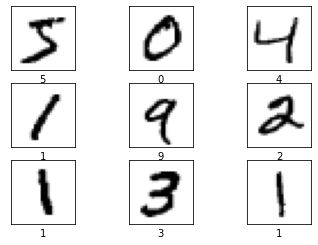

train_x.shape = (60000, 784), train_y.shape = (60000, 10)
test_x.shape = (10000, 784), test_y.shape = (10000, 10)


In [70]:
# Загрузка данных MNIST
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# Посмотрим на первые 9 примеров из тренировочной выборки
for i in range(9) :
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap=plt.cm.binary)
    plt.xlabel(train_y[i])
plt.show()


# Размер изображений в базе MNIST составляет 28x28
train_x = train_x.reshape(train_x.shape[0], 28 * 28)
test_x = test_x.reshape(test_x.shape[0], 28 * 28)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

# Нормируем интервал значений пикселей из [0, 255] в [0, 1]
train_x = train_x/255.0
test_x = test_x/255.0 

# Изначально после загрузки train_y и test_y - одномерные массивы, 
# в элементах которых записан номер класса соответствующего элемента.
# Преобразуем их в двумерную матрицу, где каждому элементу x будет соответствовать строка из 9 нулей
# и одной 1, стоящей на позиции номера класса. 
# В наборе MNIST 10 классов.
train_y = np.eye(10)[train_y]
test_y = np.eye(10)[test_y]

print('train_x.shape = {}, train_y.shape = {}'.format(train_x.shape, train_y.shape))
print('test_x.shape = {}, test_y.shape = {}'.format(test_x.shape, test_y.shape))


# 1) Проектирование и разработка программной реализации метода обратного распространения ошибки

## Метод обратного распространения ошибки

<b> Инициализация синаптических весов сети </b> (случайным образом из некоторого распределения)

Повторение следующих шагов для каждого примера
тренировочного набора данных
* 1\. Прямой проход:
    * 1.1 Вычисление значений выходных сигналов нейронов всех слоев
    * 1.2 Вычисление значений производных функций активации на каждом слое сети 
* 2\. Обратный проход:
    * 2.1. Вычисление значения целевой функции и ее градиента
    * 2.2. Корректировка синаптических весов


В качестве <b>функции активации</b>:
* на скрытом слое используется функция ReLU.
* на выходном слое используется функция softmax.
В качестве функции ошибки используется кросс-энтропия. 

<b>Критерии остановки:</b> число итераций метода (количество
проходов по всему множеству примеров), достигнутая
ошибка


In [71]:
# В качестве функции активации на скрытом слое используется функция ReLU
def ReLU(x):
    return np.maximum(0, x)

# В качестве функции активации на выходном слое используется функция softmax.
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis = 1, keepdims = True)

# В качестве функции ошибки используется кросс-энтропия.
def crossEntropyLoss(y, u):
    return np.mean(-np.sum(y * np.log(u), axis = 1))

# Функция подсчета точности на тестовой или обучающей выборке
def accuracy(x, y):
    return np.mean(np.argmax(x, axis = 1) == np.argmax(y, axis = 1))

In [86]:
class NeuralNetwork:
    # input_layer  - количество нейронов на входе
    # hidden_layer - количество нейронов на скрытом слое
    # output_layer - количество нейронов на выходе
    def __init__(self, 
                 input_neurons = 28 * 28, # количество нейронов на входе, что соответствует разрешению одноканального изображения 
                                          # (параметр; для изображений в базе MNIST составляет 28x28)
                 hidden_neurons = 300,  # количество нейронов на скрытом слое
                
                 output_neurons = 10):  # количество нейронов на выходе, что соответствует количеству классов изображений 
                                        # (параметр; для задачи классификации рукописных цифр – 10 классов)
        
        # Синаптические веса 
        self.w1 = np.random.randn(input_neurons, hidden_neurons) * 0.01
        self.w2 = np.random.randn(hidden_neurons, output_neurons) * 0.01
        
        # Воздействие внешней среды (сдвиги), представляется свободным членом
        self.b1 = np.zeros((1, hidden_neurons))
        self.b2 = np.zeros((1, output_neurons))

    # Прямой проход
    def forward(self, x):
        
        self.vs = np.dot(x, self.w1) + self.b1 # выходной сигнал нейрона скрытого слоя
        self.vs_ReLU = ReLU(self.vs) # преобразования сигнала с помощью функции активации ReLU
        
        self.uj = np.dot(self.vs_ReLU, self.w2) + self.b2 # выходной сигнал
        self.uj_softmax = softmax(self.uj) #преобразования сигнала с помощью функции активации softmax

 
    # Обратный проход (на базе стохастического градиентного спуска)
    def backward(self, x, y, learning_rate):
        
        # вычисление градиента функции ошибки
        duj = (self.uj_softmax - y) / self.uj_softmax.shape[0]
        dw2 = (self.vs_ReLU.T).dot(duj)
        db2 = np.sum(duj, axis = 0, keepdims = True)
        dReLU = np.where(self.vs > 0, 1, 0)
        dvs = duj.dot(self.w2.T) * dReLU
        dw1 = np.dot(x.T, dvs)
        db1 = np.sum(dvs, axis = 0, keepdims = True)
        
        # Корректировка синаптических весов
        self.w2 -= learning_rate * dw2
        self.b2 -= learning_rate * db2
        self.w1 -= learning_rate * dw1
        self.b1 -= learning_rate * db1
    
    # Обучение
    def train(self, x, y, 
              epochs,     # коичество эпох
              batch_size, # размер пачки
              learning_rate): # скорость обучения
        
        start = time.time()
        for epoch in range(epochs):
            start_epoch = time.time()
            for i in range(0, len(x), batch_size):
                x_curr = x[i : i + batch_size]
                y_curr = y[i : i + batch_size]
                self.forward(x_curr)
                self.backward(x_curr, y_curr, learning_rate)
        
            self.forward(x)
            print('Epoch: {}; Loss: {:.4f}; Accuracy: {:.4f}; Time: {:.4f};'
                .format(epoch, crossEntropyLoss(y, self.uj_softmax), 
                accuracy(y, self.uj_softmax), time.time() - start_epoch))
        general_train_time = time.time() - start
        print(f"total time =  {general_train_time:.4f}")
    
    # Тестирование
    def test(self, x, y):
        start = time.time()
        self.forward(x)
        print('accuracy test: {:.4f}; Loss: {:.4f}; Time = {:.4f}'
                .format(accuracy(y, self.uj_softmax), crossEntropyLoss(y, self.uj_softmax), 
                 time.time() - start))

   

# 2) Тестирование разработанной программной реализации

Обучение модели

In [91]:
# Контрольный набор параметров
batch_size = 8 # от 8 до 64
learning_rate = 0.1
hidden_neurons = 300
num_epochs = 20

network = NeuralNetwork()
network.train(train_x, train_y, num_epochs, batch_size, learning_rate)

Epoch: 0; Loss: 0.1203; Accuracy: 0.9625; Time: 36.3346;
Epoch: 1; Loss: 0.0779; Accuracy: 0.9748; Time: 36.3117;
Epoch: 2; Loss: 0.0558; Accuracy: 0.9820; Time: 36.5555;
Epoch: 3; Loss: 0.0431; Accuracy: 0.9859; Time: 36.4737;
Epoch: 4; Loss: 0.0330; Accuracy: 0.9889; Time: 36.2421;
Epoch: 5; Loss: 0.0294; Accuracy: 0.9903; Time: 36.4091;
Epoch: 6; Loss: 0.0237; Accuracy: 0.9918; Time: 36.4794;
Epoch: 7; Loss: 0.0201; Accuracy: 0.9927; Time: 36.5544;
Epoch: 8; Loss: 0.0165; Accuracy: 0.9944; Time: 36.5520;
Epoch: 9; Loss: 0.0136; Accuracy: 0.9958; Time: 36.3693;
Epoch: 10; Loss: 0.0096; Accuracy: 0.9971; Time: 37.0596;
Epoch: 11; Loss: 0.0039; Accuracy: 0.9991; Time: 37.9252;
Epoch: 12; Loss: 0.0028; Accuracy: 0.9995; Time: 36.9733;
Epoch: 13; Loss: 0.0017; Accuracy: 0.9998; Time: 36.4384;
Epoch: 14; Loss: 0.0013; Accuracy: 0.9999; Time: 36.3162;
Epoch: 15; Loss: 0.0011; Accuracy: 1.0000; Time: 36.2723;
Epoch: 16; Loss: 0.0009; Accuracy: 1.0000; Time: 36.3176;
Epoch: 17; Loss: 0.0008;

In [92]:
network.test(test_x, test_y)

accuracy test: 0.9841; Loss: 0.0749; Time = 0.3322


In [93]:
# Контрольный набор параметров
batch_size = 16 # от 8 до 64
learning_rate = 0.1
hidden_neurons = 300
num_epochs = 20

network = NeuralNetwork()
network.train(train_x, train_y, num_epochs, batch_size, learning_rate)

Epoch: 0; Loss: 0.1463; Accuracy: 0.9546; Time: 19.7846;
Epoch: 1; Loss: 0.0878; Accuracy: 0.9727; Time: 19.7405;
Epoch: 2; Loss: 0.0645; Accuracy: 0.9800; Time: 19.8275;
Epoch: 3; Loss: 0.0504; Accuracy: 0.9842; Time: 19.8773;
Epoch: 4; Loss: 0.0414; Accuracy: 0.9864; Time: 20.1547;
Epoch: 5; Loss: 0.0339; Accuracy: 0.9895; Time: 19.9791;
Epoch: 6; Loss: 0.0314; Accuracy: 0.9899; Time: 20.6945;
Epoch: 7; Loss: 0.0252; Accuracy: 0.9917; Time: 22.3425;
Epoch: 8; Loss: 0.0202; Accuracy: 0.9939; Time: 19.8494;
Epoch: 9; Loss: 0.0173; Accuracy: 0.9947; Time: 19.8816;
Epoch: 10; Loss: 0.0155; Accuracy: 0.9954; Time: 19.8191;
Epoch: 11; Loss: 0.0132; Accuracy: 0.9962; Time: 19.9553;
Epoch: 12; Loss: 0.0115; Accuracy: 0.9970; Time: 20.1550;
Epoch: 13; Loss: 0.0097; Accuracy: 0.9977; Time: 19.9254;
Epoch: 14; Loss: 0.0071; Accuracy: 0.9986; Time: 19.8918;
Epoch: 15; Loss: 0.0055; Accuracy: 0.9990; Time: 19.8280;
Epoch: 16; Loss: 0.0046; Accuracy: 0.9993; Time: 19.7959;
Epoch: 17; Loss: 0.0040;

In [94]:
network.test(test_x, test_y)

accuracy test: 0.9822; Loss: 0.0717; Time = 0.3292


In [95]:
# Контрольный набор параметров
batch_size = 64 # от 8 до 64
learning_rate = 0.1
hidden_neurons = 300
num_epochs = 20

network = NeuralNetwork()
network.train(train_x, train_y, num_epochs, batch_size, learning_rate)

Epoch: 0; Loss: 0.2845; Accuracy: 0.9148; Time: 6.9712;
Epoch: 1; Loss: 0.2028; Accuracy: 0.9407; Time: 7.0786;
Epoch: 2; Loss: 0.1546; Accuracy: 0.9551; Time: 7.1087;
Epoch: 3; Loss: 0.1240; Accuracy: 0.9644; Time: 7.3759;
Epoch: 4; Loss: 0.1034; Accuracy: 0.9704; Time: 7.1907;
Epoch: 5; Loss: 0.0884; Accuracy: 0.9747; Time: 7.0977;
Epoch: 6; Loss: 0.0773; Accuracy: 0.9779; Time: 7.1094;
Epoch: 7; Loss: 0.0682; Accuracy: 0.9807; Time: 7.0940;
Epoch: 8; Loss: 0.0608; Accuracy: 0.9830; Time: 7.0753;
Epoch: 9; Loss: 0.0545; Accuracy: 0.9849; Time: 7.0693;
Epoch: 10; Loss: 0.0494; Accuracy: 0.9863; Time: 7.0939;
Epoch: 11; Loss: 0.0449; Accuracy: 0.9875; Time: 7.2111;
Epoch: 12; Loss: 0.0411; Accuracy: 0.9885; Time: 7.0679;
Epoch: 13; Loss: 0.0375; Accuracy: 0.9897; Time: 7.0314;
Epoch: 14; Loss: 0.0345; Accuracy: 0.9908; Time: 7.0334;
Epoch: 15; Loss: 0.0319; Accuracy: 0.9917; Time: 7.0304;
Epoch: 16; Loss: 0.0295; Accuracy: 0.9923; Time: 7.0138;
Epoch: 17; Loss: 0.0273; Accuracy: 0.9932

In [96]:
network.test(test_x, test_y)

accuracy test: 0.9790; Loss: 0.0675; Time = 0.3231


# 3) Сравнение со стандартными инструментами глубокого обучения (PyTorch)

In [97]:
class NNetwork(torch.nn.Module):
    def __init__(self):
        super(NNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(28*28, hidden_neurons)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_neurons, 10)
        
      
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return torch.nn.functional.log_softmax(x, dim = 1)


nnetwork = NNetwork()
print(nnetwork)

NNetwork(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=300, out_features=10, bias=True)
)


In [98]:
def accuracy(x, y):
        return np.mean(np.argmax(x, axis = 1) == np.argmax(y, axis = 1))

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nnetwork.parameters(), lr = learning_rate)

start = time.time()
for epoch in range(num_epochs):
    start_epoch = time.time()
    for i in range(0, len(train_x), batch_size):
        x_curr = torch.tensor(train_x[i : i + batch_size])
        y_curr = torch.tensor(train_y[i : i + batch_size]) 
        
        # Прямой проход
        outputs = nnetwork(x_curr) 
        loss = loss_function(outputs, y_curr) 
        
        # Обратный проход
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
    print('Epoch: {}; Loss: {:.4f}; Accuracy: {:.4f}; Time: {:.4f};'
                .format(epoch, loss.item(), 
                accuracy(nnetwork(torch.tensor(train_x)).detach().numpy(), train_y),
                time.time() - start_epoch))


general_train_time = time.time() - start
print(f"total time = {general_train_time:.4f}")

Epoch: 0; Loss: 0.1044; Accuracy: 0.9214; Time: 2.1381;
Epoch: 1; Loss: 0.0540; Accuracy: 0.9452; Time: 2.1939;
Epoch: 2; Loss: 0.0372; Accuracy: 0.9581; Time: 2.0055;
Epoch: 3; Loss: 0.0316; Accuracy: 0.9664; Time: 2.3596;
Epoch: 4; Loss: 0.0286; Accuracy: 0.9721; Time: 2.4624;
Epoch: 5; Loss: 0.0274; Accuracy: 0.9768; Time: 2.2242;
Epoch: 6; Loss: 0.0261; Accuracy: 0.9801; Time: 2.3945;
Epoch: 7; Loss: 0.0261; Accuracy: 0.9827; Time: 2.1764;
Epoch: 8; Loss: 0.0239; Accuracy: 0.9843; Time: 2.4347;
Epoch: 9; Loss: 0.0208; Accuracy: 0.9859; Time: 2.1180;
Epoch: 10; Loss: 0.0194; Accuracy: 0.9874; Time: 2.3250;
Epoch: 11; Loss: 0.0169; Accuracy: 0.9887; Time: 2.1673;
Epoch: 12; Loss: 0.0145; Accuracy: 0.9900; Time: 2.2252;
Epoch: 13; Loss: 0.0128; Accuracy: 0.9909; Time: 2.1313;
Epoch: 14; Loss: 0.0114; Accuracy: 0.9916; Time: 2.1316;
Epoch: 15; Loss: 0.0095; Accuracy: 0.9923; Time: 2.2459;
Epoch: 16; Loss: 0.0085; Accuracy: 0.9931; Time: 2.2315;
Epoch: 17; Loss: 0.0075; Accuracy: 0.9940

In [101]:
print('accuracy test {:.4f}'
                .format(accuracy(nnetwork(torch.tensor(test_x)).detach().numpy(), test_y)))

accuracy test 0.9798


# 4) Вывод

В рамках данной лабораторной работы реализован метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полностью связанной сети (один скрытый слой). Разработанная нейронная сеть была протестирована с использованием контрольных параметров и получена точность, сравнимая со стандартными инструментами глубокого обучения: точность реализованного класса: 0.9841 (bs = 8), точность реализации из библиотеки PyTorch: 0.9798.